In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [25]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume.csv")
df.head()

,ID,Resume_str,Category
0,16852973,hr administrator marketing associate hr admini...,HR
1,22323967,hr specialist us hr operations summary versati...,HR
2,33176873,hr director summary over years experience in r...,HR
3,27018550,hr specialist summary dedicated driven and dyn...,HR
4,17812897,hr manager skill highlights hr skills hr depar...,HR


In [26]:
# Convert resumes column to a list
resumes = df["Resume_str"].tolist()
    
# Encode category labels as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(df["Category"])
category_names = encoder.classes_.tolist()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(resumes, labels, test_size=0.2, random_state=42, stratify=labels)

print("Train data size:", len(X_train))
print("Validation data size:", len(X_test))

Train data size: 1986
Validation data size: 497


In [28]:
# Load the SBERT model for generating sentence embeddings
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [29]:
# Generate SBERT embeddings for training data
X_train_embed = sbert_model.encode(X_train, show_progress_bar=True)

# Generate SBERT embeddings for test data
X_test_embed = sbert_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### Random Forest Classifier

In [30]:
def report(results, n_top=10, primary_metric='f1_weighted', secondary_metric='accuracy'):

    rank_key = f"rank_test_{primary_metric}"
    mean_key = f"mean_test_{primary_metric}"
    std_key = f"std_test_{primary_metric}"
    secondary_key = f"mean_test_{secondary_metric}"
    
    for rank in range(1, n_top + 1):

        candidates = np.flatnonzero(results[rank_key] == rank)
        for c in candidates:
            print(f"Model with rank: {rank}")
            print(f"Mean validation {primary_metric}: {results[mean_key][c]:.3f} (std: {results[std_key][c]:.3f})")
            
            if secondary_key in results:
                print(f"Mean validation {secondary_metric}: {results[secondary_key][c]:.3f}")
            
            print("Parameters:", results["params"][c])
            print("")

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42, k_neighbors=4)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=5))
])

In [33]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5, 7, 9],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= ['accuracy', 'f1_weighted'],
    refit = 'f1_weighted',
    return_train_score=True,
    n_jobs=5
)

start = time()
grid_search = grid.fit(X_train_embed, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 683.52 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation f1_weighted: 0.744 (std: 0.015)
Mean validation accuracy: 0.748
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 2
Mean validation f1_weighted: 0.742 (std: 0.017)
Mean validation accuracy: 0.745
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 3
Mean validation f1_weighted: 0.742 (std: 0.013)
Mean validation accuracy: 0.745
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 4
Mean validation f1_weighted: 0.739 (std: 0.018)
Mean validation accuracy: 0.742
Para

In [34]:
print("Best hyperparameters found:")
for name, val in grid_search.best_params_.items():
    print(f" - {name}: {val}")

Best hyperparameters found:
 - clf__criterion: gini
 - clf__max_depth: 9
 - clf__max_features: log2
 - clf__min_samples_leaf: 15
 - clf__min_samples_split: 10
 - clf__n_estimators: 700


In [35]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_embed)

In [36]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_embed, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_embed, y_test)))

Training Score: 0.91
Test Score: 0.74


In [37]:
print(classification_report(y_test, prediction, target_names=category_names, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.90      0.96      0.93        28
              ADVOCATE       0.48      0.77      0.59        13
           AGRICULTURE       0.43      0.50      0.46         6
               APPAREL       0.70      0.64      0.67        11
                  ARTS       1.00      0.20      0.33         5
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.70      0.74      0.72        19
               BANKING       0.86      0.35      0.50        17
                   BPO       0.38      0.60      0.46        10
  BUSINESS-DEVELOPMENT       0.81      0.63      0.71        35
                  CHEF       0.87      1.00      0.93        20
          CONSTRUCTION       0.90      0.86      0.88        22
            CONSULTANT       0.73      0.79      0.76        24
              DESIGNER       0.84      0.95      0.89        22
         DIGITAL-MEDIA       0.50      

<Figure size 1500x1000 with 0 Axes>

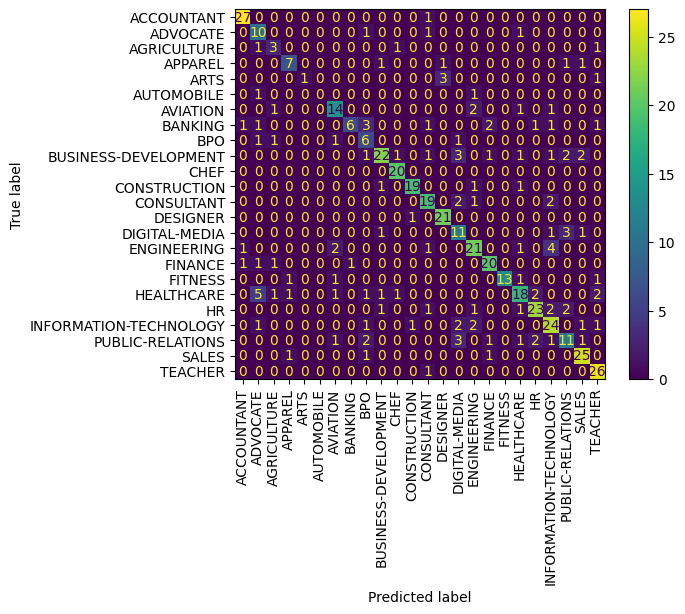

In [38]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction, display_labels=category_names)
plt.xticks(rotation=90)
plt.show()

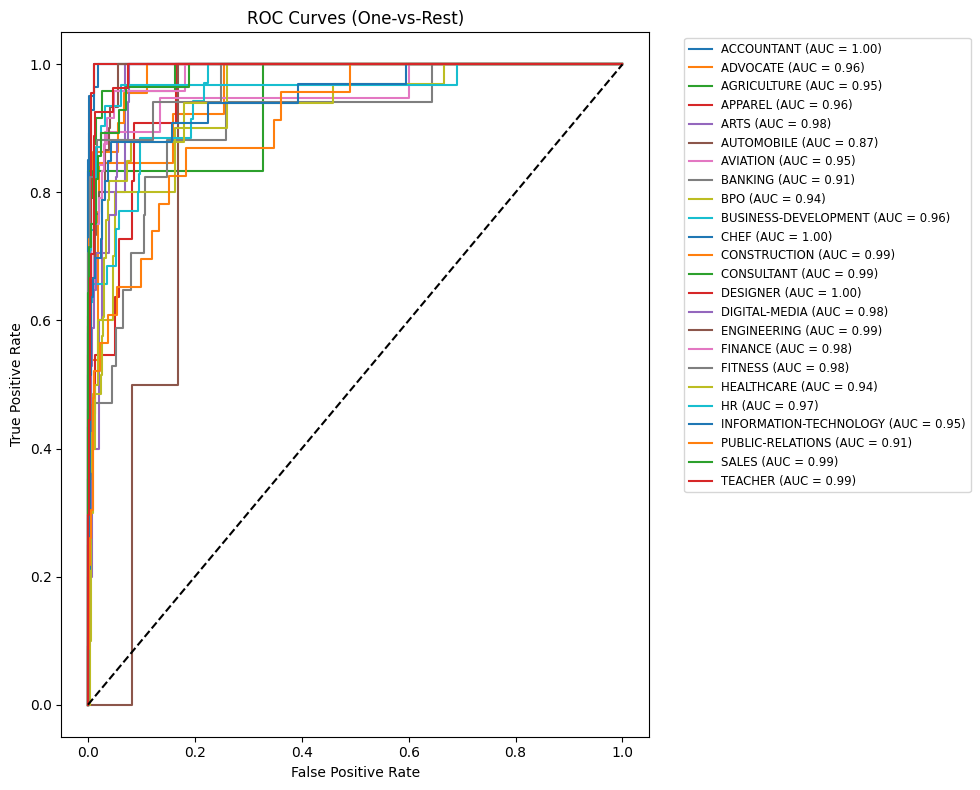

In [39]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test_embed)

plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

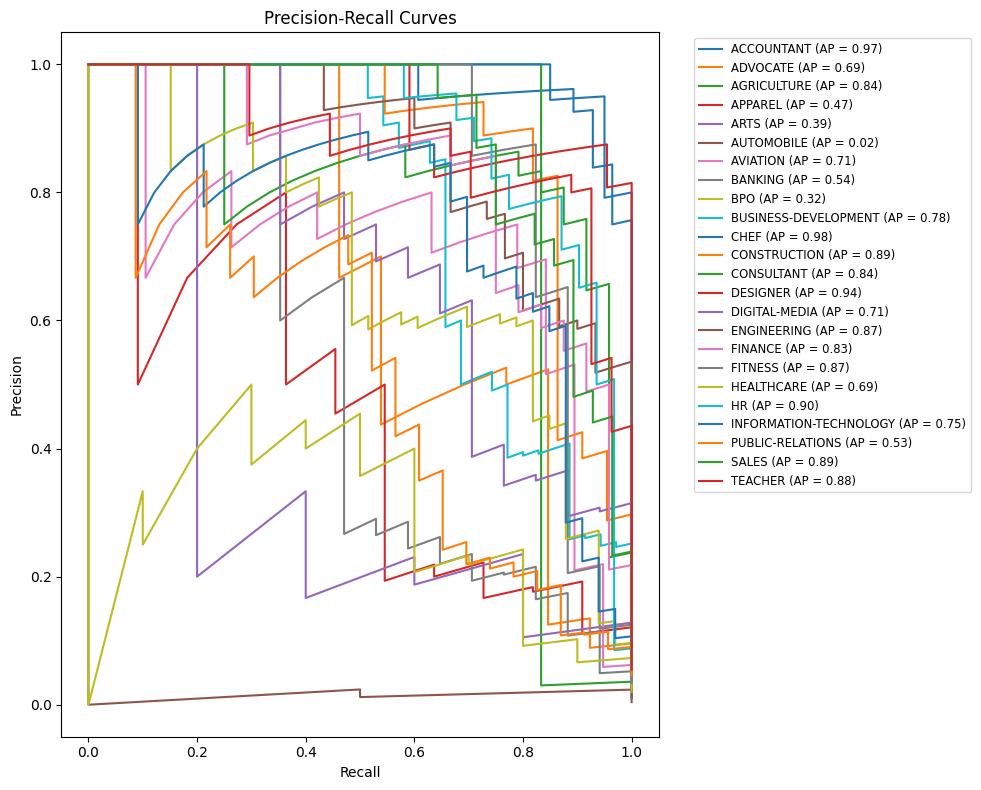

In [40]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{label} (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [41]:
import sys
sys.path.append('..')

from utils import save_experiment_BERT

save_experiment_BERT(grid_search, RF_Model_best, X_train_embed, y_train, X_test_embed, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
RandomForestClassifier(clf__criterion=gini, clf__max_depth=9, clf__max_features=log2, clf__min_samples_leaf=15, clf__min_samples_split=10, clf__n_estimators=700) | SBERT() | Accuracy train=0.906, test=0.738

